In [49]:
import jax 
import jax.numpy as jnp 
import flax.linen as nn 
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import optax
from sklearn.metrics import mean_squared_error as mse
import numpy as np
from sklearn import preprocessing

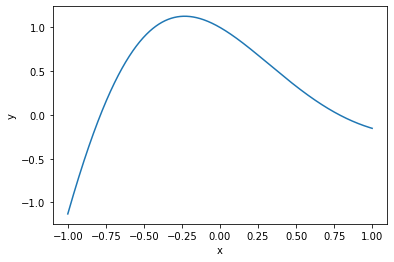

In [50]:
# function to approximate 
def f(x):
    return jnp.cos(2*jnp.prod(x, axis=1))*jnp.exp(-x[:,0])

# example in one dimension
x = jnp.linspace(-1,1,1000).reshape(-1,1)
y = f(x)
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [63]:
class Regression(nn.Module):
    num_features: int
    
    def setup(self):
        self.w = self.param('weights', jax.nn.initializers.glorot_uniform(),
                                (self.num_features,1))
        self.shift = self.param('bias', jax.nn.initializers.glorot_uniform(),
                                (1,1))
    @nn.compact
    def __call__(self, x):
        out = jnp.sum(x*self.w[:,0], axis=1)
        return out + self.shift
# initializing the optimizer
learning_rate = 1e-3
optx = optax.adam(learning_rate=learning_rate)
# A function to generate polynomial features - equivalent to fitting using a polynomial 
def generate_poly(deg_poly, x):
    poly = PolynomialFeatures(deg_poly)
    return poly.fit_transform(x)


## Fitting a single-variate function

In [64]:
#training data
x = jnp.linspace(-1,1,500).reshape(-1,1)
y = f(x)

deg_poly = 70 #degree of the polynomial
x_poly = generate_poly(deg_poly, x)
scaler = preprocessing.StandardScaler().fit(x_poly)
x_poly = scaler.transform(x_poly)
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)

# initialize the neural network 
model = Regression(deg_poly + 1)
params = model.init(jax.random.PRNGKey(0), x_test)
opt_state = optx.init(params)

# define the loss function 
@jax.jit
def MSE(params, x, y_true):
    y_pred = model.apply(params, x)
    return jnp.mean((y_pred-y_true)**2)

loss_fn = MSE
loss_grad_fn = jax.value_and_grad(MSE) # a function to evaluate the function and its gradient)

# training loop
n_epochs = 2000 #number of training epochs 
for e in range(n_epochs):
    loss_val, grad = loss_grad_fn(params, x_train, y_train)
    updates, opt_state = optx.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    if e % 100 == 0:
        print(f"epoch: {e}, loss function: {loss_val}")

epoch: 0, loss function: 1.921583890914917
epoch: 100, loss function: 0.5517544746398926
epoch: 200, loss function: 0.24463360011577606
epoch: 300, loss function: 0.149002343416214
epoch: 400, loss function: 0.09587560594081879
epoch: 500, loss function: 0.06250157207250595
epoch: 600, loss function: 0.04245973750948906
epoch: 700, loss function: 0.03080572746694088
epoch: 800, loss function: 0.02398470975458622
epoch: 900, loss function: 0.019759060814976692
epoch: 1000, loss function: 0.01685989461839199
epoch: 1100, loss function: 0.014630366116762161
epoch: 1200, loss function: 0.01275967713445425
epoch: 1300, loss function: 0.011114334687590599
epoch: 1400, loss function: 0.009642686694860458
epoch: 1500, loss function: 0.008326207287609577
epoch: 1600, loss function: 0.007157186511904001
epoch: 1700, loss function: 0.0061297048814594746
epoch: 1800, loss function: 0.005236626137048006
epoch: 1900, loss function: 0.004469005856662989


We now evaluate the training and test error. Does the model suffer from overfitting? from underfitting? from both?

training error: 0.003816316369920969, test error: 0.004423259757459164
(500, 1)


Text(0.5, 1.0, 'Functions on all data')

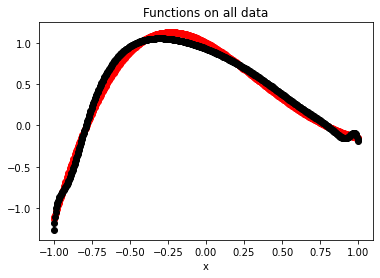

In [67]:
# evaluate the training and test errors 
tr_error = MSE(params, x_train, y_train)
te_error = MSE(params, x_test, y_test)
print(f"training error: {tr_error}, test error: {te_error}")
y_pred = model.apply(params, x_poly).T
print(y_pred.shape)
# plotting the true and predicted signal on training data 
plt.plot(x, y, marker='o', color='r', label="True function")
plt.plot(x, y_pred, marker='o', color='black', label="Approximate function")
plt.xlabel('x')
plt.title("Functions on all data")

An important question here is how complex need the approximating function be for to gain a certain accuracy. We study this question:

In [71]:
def Trainer(deg_poly, params):
    """
    Performs a full training procedure where the complexity of the training model is determined by the degree of the polynomial.
    """

    opt_state = optx.init(params)
    n_epochs = 8000 #number of training epochs 
    for e in range(n_epochs):
        loss_val, grad = loss_grad_fn(params, x_train, y_train)
        updates, opt_state = optx.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        if e % 500 == 0:
            print(f"epoch: {e}, loss function: {loss_val}")
            
    # compute training and testing errors
    
    tr_error = MSE(params, x_train, y_train)
    te_error = MSE(params, x_test, y_test)
    
    return tr_error, te_error

tr_errors = []
te_errors = []

deg_poly_list = np.linspace(2,25,5,dtype=int)
for deg_poly in deg_poly_list:
    x_poly = generate_poly(deg_poly, x)
    #putting the features on the same scale
    scaler = preprocessing.StandardScaler().fit(x_poly)
    x_poly = scaler.transform(x_poly)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)
    model = Regression(deg_poly + 1)
    params = model.init(jax.random.PRNGKey(0), x_test)
    tr_err, te_err = Trainer(deg_poly, params)
    tr_errors.append(tr_err)
    te_errors.append(te_err)
    print(f"training of for polynomial degree: {deg_poly} is done")

epoch: 0, loss function: 1.7015118598937988
epoch: 500, loss function: 0.6253057718276978
epoch: 1000, loss function: 0.22473518550395966
epoch: 1500, loss function: 0.08501800149679184
epoch: 2000, loss function: 0.0513715036213398
epoch: 2500, loss function: 0.046636007726192474
epoch: 3000, loss function: 0.04630668833851814
epoch: 3500, loss function: 0.0462973453104496
epoch: 4000, loss function: 0.046297263354063034
epoch: 4500, loss function: 0.046297263354063034
epoch: 5000, loss function: 0.046297259628772736
epoch: 5500, loss function: 0.046297263354063034
epoch: 6000, loss function: 0.046297263354063034
epoch: 6500, loss function: 0.046297263354063034
epoch: 7000, loss function: 0.046297263354063034
epoch: 7500, loss function: 0.046297263354063034
training of for polynomial degree: 2 is done
epoch: 0, loss function: 2.086591958999634
epoch: 500, loss function: 0.13295581936836243
epoch: 1000, loss function: 0.015519591979682446
epoch: 1500, loss function: 0.00795363169163465

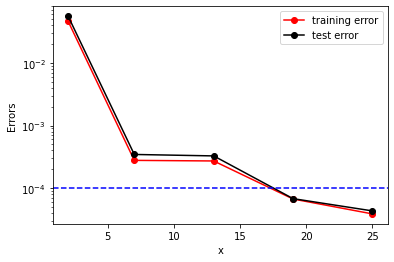

In [73]:

# plotting both errors 
plt.plot(deg_poly_list, tr_errors, marker="o", color='r', label="training error")
plt.plot(deg_poly_list, te_errors, marker="o", color='black', label="test error")
plt.axhline(y=1e-4, color='b', linestyle='--')
plt.xlabel("x")
plt.yscale('log')
plt.ylabel("Errors")
plt.legend()
plt.show()

## Fitting a multi-variate function

In [74]:
x = jnp.linspace(-1,1,500)#.reshape(-1,1)
elems = jnp.meshgrid(x,x)
# Flatten the arrays and concatenate them to get the direct product
x_mD = np.vstack([elem.ravel() for elem in elems]).T
y = f(x_mD)

In [ ]:
def Trainer(deg_poly, params):
    """
    Performs a full training procedure where the complexity of the training model is determined by the degree of the polynomial.
    """

    opt_state = optx.init(params)
    n_epochs = 8000 #number of training epochs 
    for e in range(n_epochs):
        loss_val, grad = loss_grad_fn(params, x_train, y_train)
        updates, opt_state = optx.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        if e % 500 == 0:
            print(f"epoch: {e}, loss function: {loss_val}")
            
    # compute training and testing errors
    
    tr_error = MSE(params, x_train, y_train)
    te_error = MSE(params, x_test, y_test)
    
    return tr_error, te_error

tr_errors = []
te_errors = []

deg_poly_list = np.linspace(2,25,5, dtype=int)
nfuncs = []
for deg_poly in deg_poly_list:
    x_poly = generate_poly(deg_poly, x_mD)
    scaler = preprocessing.StandardScaler().fit(x_poly)
    x_poly = scaler.transform(x_poly)
    x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.33, random_state=42)
    nfuncs.append(x_poly.shape[1])
    model = Regression(x_poly.shape[1])
    params = model.init(jax.random.PRNGKey(0), x_test)
    tr_err, te_err = Trainer(deg_poly, params)
    tr_errors.append(tr_err)
    te_errors.append(te_err)
    print(f"training of for polynomial degree: {deg_poly} is done")


epoch: 0, loss function: 2.5837583541870117
epoch: 500, loss function: 0.6473450660705566
epoch: 1000, loss function: 0.1923411339521408
epoch: 1500, loss function: 0.10181887447834015
epoch: 2000, loss function: 0.09034041315317154
epoch: 2500, loss function: 0.0896039605140686
epoch: 3000, loss function: 0.08958495408296585
epoch: 3500, loss function: 0.08958480507135391
epoch: 4000, loss function: 0.08958480507135391
epoch: 4500, loss function: 0.08958480507135391
epoch: 5000, loss function: 0.08958480507135391
epoch: 5500, loss function: 0.08958480507135391
epoch: 6000, loss function: 0.08958480507135391
epoch: 6500, loss function: 0.08958480507135391
epoch: 7000, loss function: 0.08958480507135391
epoch: 7500, loss function: 0.08958480507135391
training of for polynomial degree: 2 is done
epoch: 0, loss function: 1.743695855140686
epoch: 500, loss function: 0.1911543607711792
epoch: 1000, loss function: 0.028419973328709602
epoch: 1500, loss function: 0.004692111164331436
epoch: 2

In [22]:

# plotting both errors 
plt.plot(n_funcs, tr_errors, marker="o", color='r', label="training error")
plt.plot(n_funcs, te_errors, marker="o", color='black', label="test error")
plt.axhline(y=0.2, color='b', linestyle='--')
plt.xlabel("x")
plt.ylabel("Errors")
plt.legend()
plt.show()

NameError: name 'n_funcs' is not defined